In [1]:
from netCDF4 import Dataset
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from cdo import *
from scipy import stats
import _pickle as cpickle
import inspect
import numbers
cdo = Cdo()

<span style="color:red">NOTE:</span> 
The analyses presented below is done on annual bases (i.e. not seasonal or monthly). 
Subsetting for location, time, levels needs to be explored further through:

<ol> 
    <li>Custom functions using only netCDF4 libraries</li>
    <li>Using xarray</li>
    <li>Using iris</li>

### 1. Loading the datasets

##### 1.1 Specify the data directory

In [249]:
data_dir = '/home/abhi/Documents/data/'

##### 1.2 Specify the file paths of observation and model data

In [250]:
files = {'obs':'OBSERVATION/IMD/precip/imdCAL.nc',
         'mod': '/home/abhi/Documents/data/PRECIS/base/precip/1971-2000_rm_ll25.nc'}

##### 1.3 Make a dictionary to hold the datasets

In [251]:
data = {'obs': None, 'mod': None}

##### 1.4 Load the netcdf datasets into the data dictionary

In [252]:

for file_type, file in files.items():
    abs_path = join(data_dir, file)
    var_name = cdo.showvar(input=abs_path)[0]
    data[file_type] = Dataset(abs_path).variables[var_name][:]
    


##### 1.5 Load the list of time from either of the two datasets

In [6]:
dates = cdo.showdate(input=abs_path)[0]
dates = pd.to_datetime(pd.Series(dates.split('  ')), format="%Y-%m-%d", errors='coerce')


##### 1.6 Load the longitude and latitude arrays from either of the dataset

In [190]:
abs_path = join(data_dir, files['obs'])

lon = Dataset(abs_path).variables['lon'][:]
lat = Dataset(abs_path).variables['lat'][:]


### 2. What is the precipitation threshold ?

#### 2.1 Let's calculate the precentage rainy days (pr > 0) on an annual bases

In [319]:
# The observation data
obs = data['obs']

In [320]:
# Appy along the time axis (axis=0), 
# a function which calculates the number of days with precip > 0
rainydays = np.apply_along_axis(lambda x: x[x>0].size, 0, obs)

In [321]:
# Verify the shape
rainydays.shape

(129, 135)

In [322]:
# The returned array is not masked
# Make a masked array using the mask attribute from the obs data
rainydays = np.ma.masked_array(data=rainydays, mask=obs.mask[0])

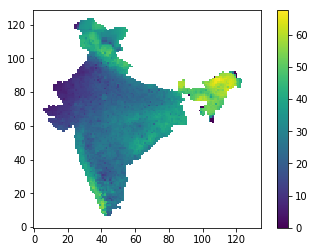

In [323]:
# Lets's plot the percentage of rainy days for each location
plt.imshow((rainydays/10800)*100, origin='lower')
cbar = plt.colorbar()

#### 2.2 Let's make it into a function

In [12]:
def getRainyDays(data, axis=0, plot=False):
    '''
    Returns the number of rainy days for each grid location
    Parameters:
        data: The input precipitation data
        axis : The time axis (Default=0)
    '''
    
    # Appy along the time axis (axis=0), 
    # a function which calculates the number of days with precip > 0
    rainydays = np.apply_along_axis(lambda x: x[x>0].size, 0, data)    
    
    # The returned array is not masked
    # Make a masked array using the mask attribute from the obs data
    try:
        rainydays = np.ma.masked_array(rainydays, mask=data.mask[0])
        
    except AttributeError:
        print('Mask not applied! No mask attribute found')
    
    if plot:
        # Lets's plot the percentage of rainy days for each location
        fig, ax = plt.subplots()
        img = ax.imshow((rainydays/10800)*100, origin='lower')
        fig.suptitle('Percentage wet days (precip > 0mm)')
        cbar = plt.colorbar(ax=ax, mappable=img)
        plt.close()
        
        return rainydays, fig
        
    return rainydays

In [13]:
rainydays, fig = getRainyDays(obs, plot=True)

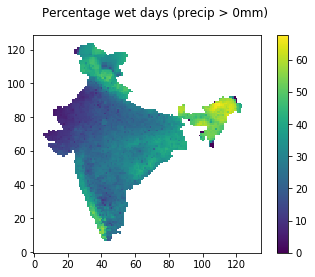

In [14]:
fig

### 3. Calculate it for both observation and model data ==> put it into a dict

### 4. Plotting the wet day frequency for both ==> Annual

###### 4.1 Threshold applying function. All values below the threshold are mapped to zero

In [15]:
def apply_thresh(data, thresh=0):
    result = data.copy() ## Avoid changing the original
    result[result < thresh] = 0
    return result

In [324]:
rainydays = {'obs': getRainyDays(data['obs']),}

###### 4.1.1 Choose a threshold

In [325]:
thresh = 0.01
rainydays['mod'] = getRainyDays(apply_thresh(data['mod'], thresh))

In [111]:
pd.DataFrame({'wetDayFreqBias':
              np.mean((rainydays['mod']/10800)*100) - np.mean(rainydays['obs']/10800*100)
             }
             ,index=[thresh])

,wetDayFreqBias
0.01,12.717882


###### 4.1.2 Let's test this for various thresholds

###### 4.1.2.1 Apply various thresholds, and calculate % wet day frequency biases

In [297]:
wetdaybias_spatial = lambda thresh: (getRainyDays(apply_thresh(data['mod'], thresh)) \
                                     - getRainyDays(data['obs']))*100/10800

wetdaybias_spatial.__doc__ = 'Calculates % wet day frequency bias for a given threshold'

###### <span style="color:red">WARNING!</span> do not run the below cell! Instead load the pickled object from the next cell

In [104]:
%%time
spatial_threshes = []

for thresh in np.arange(0, 10.01, 0.01):
    spatial_threshes.append(wetdaybias_spatial(thresh))
    
arr = np.array(spatial_threshes)
arr = np.ma.masked_array(arr, mask=data['mod'].mask[0:1001, :, :], )

with open('../../output/pickled_objects/diag1_spatialthresharr.pickle', 'wb') as pickleObject:
    cpickle.dump(arr, pickleObject)

(1001, 129, 135)

###### 4.1.2.2  <span style="color:green">LOAD</span> the pickled object containing the spatial wet day biases for different thresholds

In [ ]:
with open('../../output/pickled_objects/diag1_spatialthresharr.pickle', 'rb') as pickleObject:
    arr = cpickle.load(pickleObject)

###### 4.1.2.3 Find the index of least wet day frequency bias for each grid point and plot

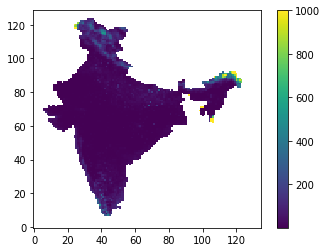

In [298]:
arr_argmin = np.ma.masked_array(np.abs(arr).argmin(axis=0), mask=data['mod'].mask[0, :,:])
plt.imshow(arr_argmin, origin='lower')
plt.colorbar()

###### 4.1.2.4 Vectorized function to convert the indices obtained in above arr (arr_argmin) to ==> actual thresholds applied

In [ ]:
@np.vectorize
def change_to_thresh(cell_val, ):
    '''
    Mapping threshold values to the original array.
    Use: Finding threshold index of minimum wet day
         frequency bias
    '''
    mapping_arr=np.arange(0, 10.01, 0.01)
    if type(cell_val) is not np.ma.core.MaskedConstant:
        return mapping_arr[cell_val]
    else:
        return cell_val


###### 4.1.2.5 Plot the thresholds (which minimize wet day frequency bias) for each grid point

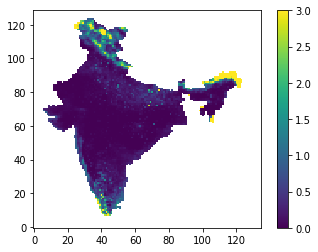

In [303]:
plt.imshow(change_to_thresh(arr_argmin),origin='lower', vmin=0, vmax=3)
plt.colorbar()

###### 4.1.2.6 Let's see which threshold is the most suited (in minimizing wet day frequency bias) accross all grid points

In [ ]:
changed_arr = change_to_thresh(arr_argmin)
changed_arr = changed_arr[changed_arr.mask == False].data

(-0.01, 2)

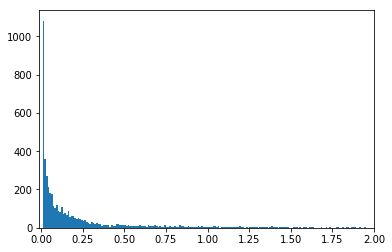

In [302]:
histplot = plt.hist(changed_arr, bins=np.arange(0, 10.01, 0.01))
plt.xlim(-0.01, 2)


###### 4.1.2.7 Create a df to see variation of wet day frequency bias with applied threshold

In [154]:
df = pd.DataFrame({'wetDayFreqBias':
              arr.mean(axis=tuple(range(1, arr.ndim)))
             },
             index=np.arange(0, 10.01, 0.01)
            )

In [165]:
df.head()

,wetDayFreqBias
0.00,37.219059
0.01,12.717882
0.02,10.129307
0.03,8.531779
0.04,7.355900


Text(0.5,0.98,'% wet day frequency bias v/s applied threshold')

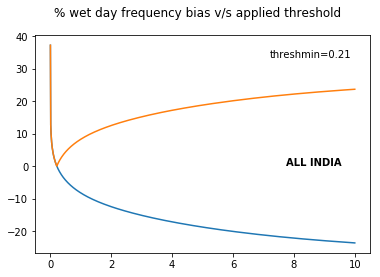

In [184]:
fig, ax = plt.subplots()
ax.plot(df)
ax.plot(df.abs())
threshmin = df.abs().idxmin()[0]
ax.annotate(f'threshmin={threshmin}', xy=(0.7, 0.9), xycoords='axes fraction')
ax.annotate('ALL INDIA', xy=(0.75, 0.4), xycoords='axes fraction', fontweight='bold')
fig.suptitle('% wet day frequency bias v/s applied threshold')

###### 4.1.2.8 For a particular location (Use with getclosest_lonlat)

In [313]:
def wetdaybias(thresh, loni, lati):
    if not np.isnan(data['obs'][:, loni, lati]).any():
        obs = getRainyDays(data['obs'][:, loni, lati])
        mod = getRainyDays(apply_thresh(data['mod'][:, loni, lati], thresh))
        
        return (mod - obs)*100/data['mod'].size
    else:
        print('NaN values in the data')
        return np.nan

In [314]:
def get_thresh(loni, lati, threshlist=np.arange(0, 1.01, 0.01)):
    res = []
    for thresh in threshlist:
        res.append(wetdaybias(thresh, loni, lati))

    res = np.array(res)
    return res, threshlist[np.abs(res).argmin()]

In [315]:
loc = (50, 50)

Text(0.7,0.4,'loc=(79.0, 19.0)')

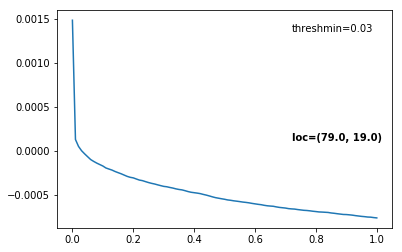

In [316]:
fig, ax = plt.subplots()
threshlist=np.arange(0, 1.01, 0.01)
thresh_bias, threshmin = get_thresh(*loc)
ax.plot(threshlist, thresh_bias)
ax.annotate(f'threshmin={threshmin}', xy=(0.7, 0.9), xycoords='axes fraction')
ax.annotate(f'loc={(lon[loc[0]], lat[loc[1]])}', 
            xy=(0.7, 0.4), xycoords='axes fraction',
            fontweight='bold')


###### 4.1.2.9 Function to get the closes lon, lat in the grid. Also can be used to subset data.

In [329]:
def getclosest_lonlat(lonpt, latpt, 
                  lons, lats, 
                  return_vals=['coords', 'coord_indices'], 
                  data=None):
    '''
    Returns the closest lon, lat in the grid (least squares distance)
    
    Parameters:
        lonpt: Desired lon
        latpt: Desired lat
        lons:  np array of longitudes
        lats:  np array of latitudes
        data:  np.ndarray to be subsetted 
               WARNING! : (checks axes ==> (1,2) and (0,1))
        
    '''
    
    allpts = np.array(np.meshgrid(lons, lats)).T.reshape(-1, 2)
    sq_dist = np.sum(((allpts - [lonpt, latpt])**2), axis=1)
    lon_val, lat_val = allpts[sq_dist.argmin()]
    
    output = dict()
    if 'coords' in return_vals:
        output['coords'] = (lon_val, lat_val)
        
    if 'coord_indices' in return_vals:
        output['coord_indices'] = (np.where(lons == lon_val)[0][0], np.where(lats == lat_val)[0][0])
        
    if data is not None:
        try:
            output['data_vals'] = data[:, output['coord_indices'][0], output['coord_indices'][1]]
        except IndexError:
            output['data_vals'] = data[output['coord_indices'][0], output['coord_indices'][1]]
        
        
    return output

In [330]:
getclosest_lonlat(82.2, 28, lon, lat, data=data['mod'])

{'coords': (82.25, 28.0),
 'coord_indices': (63, 86),
 'data_vals': masked_array(data=[6.594943261006847e-05, 4.958503632224165e-05, 0.0, ...,
                    0.04844289645552635, 0.0, 0.0],
              mask=[False, False, False, ..., False, False, False],
        fill_value=2e+20,
             dtype=float32)}

###### 4.1.2.10 Plot the % wet days in observation and model data (post application of threshold)

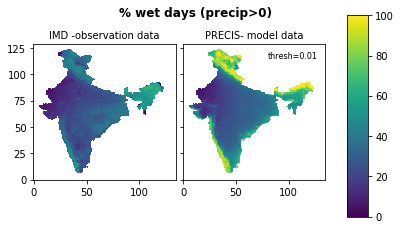

In [317]:

fig, axn = plt.subplots(1, 2)

i = 0
for type_data, rainy_data in rainydays.items():  ## using var_name rainy_data otherwise it will override data var
    img = axn[i].imshow((rainy_data/10800)*100, origin='lower', vmin=0, vmax=100)
    i += 1

# Hack to get access to autcomplete attributes
ax = axn[0]
ax.set_title('IMD -observation data', fontdict={'size': 10})

ax = axn[1]
ax.set_title('PRECIS- model data',fontdict={'size': 10})
ax.set_yticklabels([])
ax.annotate(f'thresh={thresh}', xy=(0.6, 0.9), xycoords='axes fraction', size=8)


# Adjustments to properly add the cbar axes
fig.subplots_adjust(right=0.8, top=1.1, wspace=0.05)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.7])  # See if you can do it w/o hit and trial
fig.colorbar(img, cbar_ax)

# Adjustments again
# kwargs fontdict doesn't work
suptitle = fig.suptitle('% wet days (precip>0)', weight='bold')

The pattern suggests we can perform bias correction (to correct wet-day frequency in a zone wise manner)?
Would a single threshold work over all of India?

##### 4.2 What is the difference in wet day frequencies after applying the threshold?

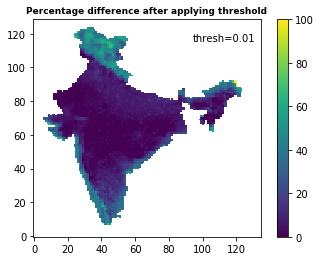

In [109]:
wetdaybias_arr = (rainydays['mod'] - rainydays['obs'])*100/10800 # The percentage bias in wet day frequency
plt.imshow(wetdaybias_arr, origin='lower', vmin=0, vmax=100)
plt.title('Percentage difference after applying threshold', size=9, fontweight='bold')
plt.annotate(f'thresh={thresh}', xy=(0.7, 0.9), xycoords='axes fraction')
plt.colorbar()

In [ ]:
wetdaybias_spatial = lambda thresh: (getRainyDays(apply_thresh(data['mod'], thresh)) \
                                     - getRainyDays(data['obs']))*100/10800

### 5. But does the annual mean bias pattern correspond to this?
The western ghats have a high dry bias although the wet day frequency is higher as well!

Text(0.5,1,'Annual Mean precipitation bias')

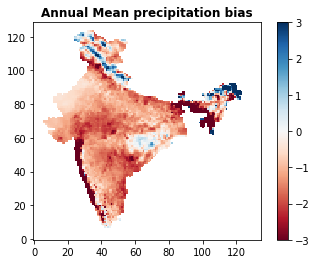

In [326]:
bias = np.mean(data['mod'] - data['obs'], axis=0)
im = plt.imshow(bias, origin='lower', vmin=-3, vmax=3, cmap='RdBu')
plt.colorbar(im)
plt.title('Annual Mean precipitation bias', weight='bold')